## Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
!pip install git+https://github.com/albumentations-team/albumentations.git
!pip install albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-2jzqi8xp
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-2jzqi8xp
  Resolved https://github.com/albumentations-team/albumentations.git to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.1-py3-none-any.whl size=125700 sha256=b0ffe3a4d9818c967b99cf8cc7d7d2055936dca2ee89c3e2bf352c2c2d65f3a1
  Stored in directory: /tmp/pip-ephem-wheel-cache-3zkzx0oo/wheels/f9/34/b6/eb7adf92e69b5629d7de6904c0d4ac4e5050b18ce065bab4e1
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentat

In [3]:
from albumentations.pytorch import ToTensorV2

from google.colab import drive
drive.mount('/content/drive')

BASE_DIR='/content/drive/My Drive/session8'
%cd $BASE_DIR

Mounted at /content/drive
/content/drive/My Drive/session8


In [5]:
import model_GN as m
from dataloader import trainloader,testloader

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


## Model Summary

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = m.Net().to(device)
summary(model, input_size=(3, 32, 32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             216
              ReLU-2            [-1, 8, 32, 32]               0
         GroupNorm-3            [-1, 8, 32, 32]              16
           Dropout-4            [-1, 8, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           1,152
              ReLU-6           [-1, 16, 32, 32]               0
         GroupNorm-7           [-1, 16, 32, 32]              32
           Dropout-8           [-1, 16, 32, 32]               0
            Conv2d-9            [-1, 8, 16, 16]             136
        MaxPool2d-10              [-1, 8, 8, 8]               0
           Conv2d-11             [-1, 16, 8, 8]           1,152
             ReLU-12             [-1, 16, 8, 8]               0

## Define Train & Test Functions

In [8]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, lambda_l1, train_losses, train_acc):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    #L1 Regularization
    if lambda_l1 > 0:
        l1 = 0
        for p in model.parameters():
          l1 = l1 + p.abs().sum()
        loss = loss + lambda_l1*l1

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    pred = y_pred.argmax(dim=1, keepdim = True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, test_losses, test_acc):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

## Define Model Run Function

In [9]:
from torch.optim.lr_scheduler import LambdaLR

def run_model(model, lambda_l1, device, train_loader, test_loader):

    train_losses = []
    test_losses = []
    train_acc = []
    test_acc = []

    optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)


    ## Removing LR scheduler for these experiments
    #lambda1 = lambda epoch: 0.65 ** epoch
    #scheduler = LambdaLR(optimizer, lr_lambda=lambda1)

    EPOCHS = 20
    for epoch in range(EPOCHS):
        print("EPOCH:", epoch + 1)
        train(model, device, train_loader, optimizer, lambda_l1, train_losses, train_acc)
        test(model, device, test_loader, test_losses, test_acc)

    return train_acc, train_losses, test_acc, test_losses

## Run Experiments

In [10]:
train_acc, train_losses, test_acc, test_losses = run_model(model, 0.05, device, trainloader, testloader)

EPOCH: 1


Loss=3.2141292095184326 Batch_id=390 Accuracy=10.07: 100%|██████████| 391/391 [00:19<00:00, 20.21it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 2


Loss=3.1966288089752197 Batch_id=390 Accuracy=10.19: 100%|██████████| 391/391 [00:13<00:00, 29.70it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 3


Loss=3.2013449668884277 Batch_id=390 Accuracy=10.14: 100%|██████████| 391/391 [00:12<00:00, 30.26it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 4


Loss=3.195924758911133 Batch_id=390 Accuracy=9.99: 100%|██████████| 391/391 [00:12<00:00, 30.12it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 5


Loss=3.213101863861084 Batch_id=390 Accuracy=10.09: 100%|██████████| 391/391 [00:13<00:00, 29.46it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 6


Loss=3.2194876670837402 Batch_id=390 Accuracy=9.80: 100%|██████████| 391/391 [00:13<00:00, 29.72it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 7


Loss=3.2172365188598633 Batch_id=390 Accuracy=10.00: 100%|██████████| 391/391 [00:13<00:00, 29.30it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 8


Loss=3.1993815898895264 Batch_id=390 Accuracy=10.24: 100%|██████████| 391/391 [00:15<00:00, 24.83it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 9


Loss=3.216089963912964 Batch_id=390 Accuracy=10.12: 100%|██████████| 391/391 [00:13<00:00, 29.87it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 10


Loss=3.2100160121917725 Batch_id=390 Accuracy=9.83: 100%|██████████| 391/391 [00:12<00:00, 30.63it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 11


Loss=3.20080828666687 Batch_id=390 Accuracy=9.84: 100%|██████████| 391/391 [00:12<00:00, 31.67it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 12


Loss=3.206130027770996 Batch_id=390 Accuracy=9.81: 100%|██████████| 391/391 [00:12<00:00, 32.57it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 13


Loss=3.2259249687194824 Batch_id=390 Accuracy=9.82: 100%|██████████| 391/391 [00:11<00:00, 32.87it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 14


Loss=3.2174055576324463 Batch_id=390 Accuracy=10.28: 100%|██████████| 391/391 [00:11<00:00, 32.62it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 15


Loss=3.211031913757324 Batch_id=390 Accuracy=9.87: 100%|██████████| 391/391 [00:11<00:00, 33.02it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 16


Loss=3.2334232330322266 Batch_id=390 Accuracy=10.01: 100%|██████████| 391/391 [00:12<00:00, 31.75it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 17


Loss=3.2210135459899902 Batch_id=390 Accuracy=10.02: 100%|██████████| 391/391 [00:12<00:00, 31.50it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 18


Loss=3.2124109268188477 Batch_id=390 Accuracy=10.05: 100%|██████████| 391/391 [00:12<00:00, 31.23it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 19


Loss=3.2036402225494385 Batch_id=390 Accuracy=9.97: 100%|██████████| 391/391 [00:13<00:00, 29.47it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 20


Loss=3.207479953765869 Batch_id=390 Accuracy=10.00: 100%|██████████| 391/391 [00:13<00:00, 29.45it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)



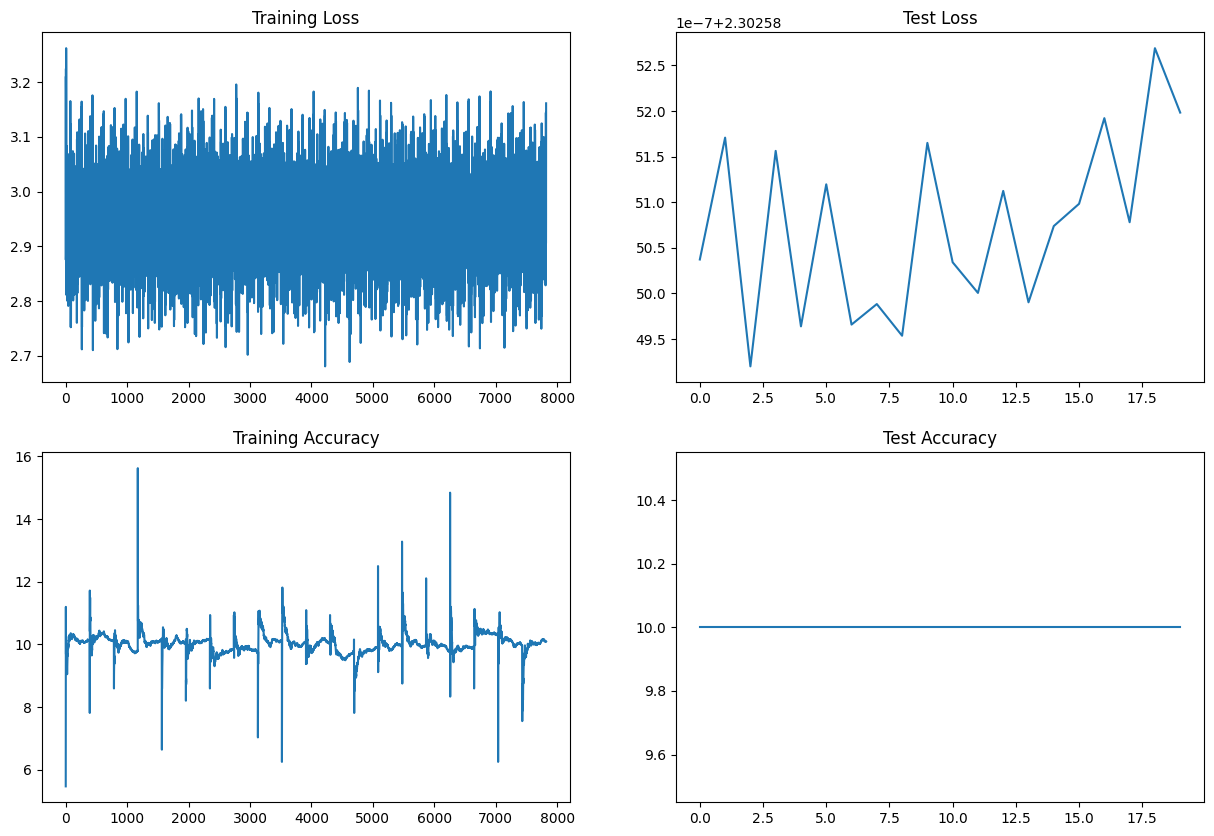

In [ ]:
def draw_graphs():
    t = [t_items.item() for t_items in train_losses]
    fig, axs = plt.subplots(2,2,figsize=(15,10))
    axs[0, 0].plot(t)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_acc)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_acc)
    axs[1, 1].set_title("Test Accuracy")
draw_graphs()